## BMIF 804 Assignment 2


In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

In [39]:
intra_mri = sitk.ReadImage("C:/Users/thish/Documents/804/Assign2/intraop_mri_new.nrrd")

def print_info(img):
    print("Image size:", img.GetSize(), "with a height of", img.GetHeight(), ", width of", img.GetWidth(), "and a depth of", img.GetDepth())
    print("Image spacing:", img.GetSpacing())
    print("Image origin:", img.GetOrigin())
    print("Image direction:", img.GetDirection())
    print("Image pixel type:", img.GetPixelIDTypeAsString())

print_info(intra_mri)

Image size: (140, 280, 45) with a height of 280 , width of 140 and a depth of 45
Image spacing: (2.0, 1.0, 4.0)
Image origin: (-140.0, -139.5, -90.0)
Image direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Image pixel type: 32-bit signed integer


In [3]:
viewer = sitk.ImageViewer()
slicer_app_location = "C:\\Users\\thish\\AppData\\Local\\NA-MIC\\Slicer 5.0.2\\Slicer.exe"
viewer.SetApplication(slicer_app_location)

viewer.Execute(intra_mri)

Calculate the physical extent of the volumetric image in mm. Make sure you consider where the origin of the image is in the physical space (in mm). You should use two different approaches for this purpose:
i. Calculate the physical extents from the meta-information you already have
 --> ii. Use the function TransformIndexToPhysicalPoint
Compare the results – if there is a difference, explain why

(-140.0, -139.5, -90.0)


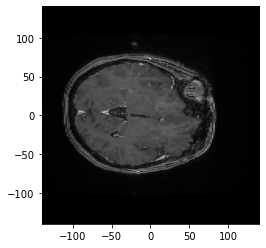

"plt.imshow(mri_array, cmap='gray', extent=[corner_point1[0],corner_point2[0], corner_point1[1],corner_point2[1]])\nplt.show()"

In [19]:
imSpacing =intra_mri.GetSpacing()
imSize= intra_mri.GetSize()
imOrigin=intra_mri.GetOrigin()

slice_num = 20
x0 =  imOrigin[0]
x1 =  imOrigin[0]+(imSpacing[0]*imSize[0])
y0 =  imOrigin[1]
y1 =  imOrigin[1]+(imSpacing[1]*imSize[1])
'''z0 =  imOrigin[2]
z1 =  imOrigin[2]+(imSpacing[2]*imSize[2])'''


img = intra_mri[:,:, slice_num]
corner_point1 = img.TransformIndexToPhysicalPoint((0,0))

#img.TransformIndexToPhysicalPoint((intra_mri.GetWidth(),0)),
corner_point2 = img.TransformIndexToPhysicalPoint((intra_mri.GetWidth(), intra_mri.GetHeight())),
#img.TransformIndexToPhysicalPoint((0, intra_mri.GetHeight()))

mri_array = sitk.GetArrayFromImage(intra_mri[:,:,slice_num])

print(intra_mri.TransformIndexToPhysicalPoint([0,0,0]))
plt.imshow(mri_array, cmap='gray', extent=[x0,x1,y0,y1])
plt.show()
# extent=[left, right, bottom, top]
plt.imshow(mri_array, cmap='gray', extent=[corner_point1[0],corner_point2[0], corner_point1[1],corner_point2[1]])
plt.show()
# plt.imshow(mri_array, cmap='gray', extent=[])


## Part 1c



The goal is to up-sample the image volume to a higher resolution with isotropic voxel spacing of (0.5 mm, 0.5 mm, 0.5 mm) so that it matches the preoperative volume. You should be able to calculate the meta-data of the resampled image before coding it. Please calculate the new meta-data (size, spacing, origin) and explain if meta-data (direction, pixel type) will be different or similar to the volume prior to upsampling. Add your calculations and explanation in your Jupyter notebook as a Markdown cell.


d. Next, write a function data_resample that will resample the Image object img to the spacing specified by its input parameter new_spacing. Use ResampleImageFilter()from SimpleITK for your implementation. Use the function to resample the intra-operative image with voxel spacing of (0.5 mm, 0.5 mm, 0.5 mm). Use the external viewer to open the resampled image in 3D Slicer and add
the screenshot of a “Four-up” layout with visible 3D view to your Jupyter notebook.
e. Print the meta-information of the resampled image and compare it with your previous calculation in part 1.c. Do they match?

In [40]:
# Part 1d:
# got the formula to change size from: https://discourse.itk.org/t/isotropic-resampling-of-a-ct-scan/4160
def data_resample(img, new_spacing):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(img)
    resampler.SetOutputSpacing([new_spacing,new_spacing,new_spacing])
    x_size = round(img.GetSize()[0]*img.GetSpacing()[0]/new_spacing)
    y_size = round(img.GetSize()[1]*img.GetSpacing()[1]/new_spacing)
    z_size = round(img.GetSize()[2]*img.GetSpacing()[2]/new_spacing)
    resampler.SetSize([x_size, y_size, z_size])
    resampled_mri = resampler.Execute(img)
    return resampled_mri

resampled_mri = data_resample(intra_mri, 0.5)
mri_array_resamp = sitk.GetArrayFromImage(resampled_mri)

viewer.Execute(resampled_mri)

print_info(resampled_mri)

Image size: (560, 560, 360) with a height of 560 , width of 560 and a depth of 360
Image spacing: (0.5, 0.5, 0.5)
Image origin: (-140.0, -139.5, -90.0)
Image direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Image pixel type: 32-bit signed integer


## Part 2:


To align the pre-operative and intra-operative images, you are asked to transform the resampled volume (part 1.d). The transformation consists of two components:
i. Rotation: in LP plane, counterclockwise, 90 degree, with respect to the physical location of the middle of the volume (e.g. if the image has a size of (m,n,k), the rotation would be around the pixel (m/2,n/2,k/2))
ii. Transformation: 10 mm towards R, 10 mm towards P, 10 mm towards S 

Generate two separate Euler3DTransform functions for rotation and translation corresponding to i and ii above.
b. Apply the transformations to the resampled volume to generate a transformed volume. You should try two different orders to apply the transformations:
i. Rotation → translation
ii. Translation → rotation

In [64]:
rotate = sitk.Euler3DTransform()
rotate.SetCenter(resampled_mri.TransformContinuousIndexToPhysicalPoint((resampled_mri.GetWidth()/2, resampled_mri.GetHeight()/2, resampled_mri.GetDepth()/2)))
rotate.SetRotation(0,0,-np.pi/2)

translation = sitk.TranslationTransform(3, [10,10,10])
translate = sitk.Euler3DTransform()
translate.SetTranslation(translation.GetOffset())
# print(translation)


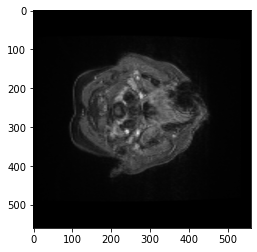

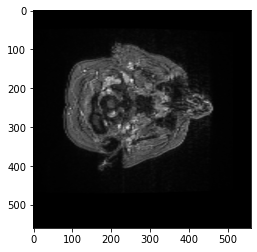

In [65]:
interpol = sitk.sitkLinear
Rot_trans_mri = sitk.Resample(resampled_mri, rotate, interpol)
Trans_mri = sitk.Resample(resampled_mri, translate, interpol)

plt.imshow(mri_array_resamp[slice_num,:,:], cmap='gray')
plt.show()

mri_array_resamp_rot = sitk.GetArrayFromImage(Rot_trans_mri)
mri_array_resamp_tran = sitk.GetArrayFromImage(Trans_mri)

#plt.imshow(mri_array_resamp_rot[slice_num,:,:], cmap='gray')
#plt.show()

plt.imshow(mri_array_resamp_tran[slice_num,:,:], cmap='gray')
plt.show()


c. Use the external viewer to open each of the transformed volumes (i and ii) in 3D Slicer and add the screenshot of a “Four-up” layout with visible 3D view to your Notebook. Is the final volume sensitive to the order of the transformations? Why or why not?
